In [5]:
# Tế bào 1: Import thư viện
import pandas as pd
import numpy as np
import re
import os
from tqdm.notebook import tqdm
import warnings

# Cấu hình để hiển thị tất cả các cột và định dạng float
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
# Bỏ qua các cảnh báo không quan trọng
warnings.filterwarnings('ignore')

print("Libraries imported and configured successfully.")


✅ Libraries imported and configured successfully.


In [6]:
# Tế bào 2: Tải dữ liệu từ hai nguồn (SR Legacy và Foundation)

# --- Objective ---
# Tải tất cả các file CSV cần thiết từ cả hai bộ dữ liệu USDA,
# chỉ lấy các cột cần thiết để tối ưu hóa việc sử dụng bộ nhớ RAM 8GB.

# --- Implementation ---
print("--- Step 1: Extracting data from USDA sources ---")
# !!! QUAN TRỌNG: Hãy đảm bảo tên thư mục bên dưới là chính xác !!!
BASE_DATA_PATH = os.path.expanduser('~/Desktop/')
SR_LEGACY_PATH = os.path.join(BASE_DATA_PATH, 'FoodData_Central_sr_legacy_food_csv_2018-04') # Thay bằng tên thư mục của em
FOUNDATION_PATH = os.path.join(BASE_DATA_PATH, 'FoodData_Central_foundation_food_csv_2025-04-24') # Thay bằng tên thư mục của em
FOOD_DOT_COM_PATH = os.path.join(BASE_DATA_PATH, 'Food.com Recipes and Interactions')

--- Step 1: Extracting data from USDA sources ---


In [7]:
try:
    # Tải từ SR Legacy
    sr_food_df = pd.read_csv(os.path.join(SR_LEGACY_PATH, 'food.csv'), usecols=['fdc_id', 'description'])
    sr_food_nutrient_df = pd.read_csv(os.path.join(SR_LEGACY_PATH, 'food_nutrient.csv'), usecols=['fdc_id', 'nutrient_id', 'amount'])
    
    # Tải từ Foundation
    foundation_food_df = pd.read_csv(os.path.join(FOUNDATION_PATH, 'food.csv'), usecols=['fdc_id', 'description'])
    foundation_food_nutrient_df = pd.read_csv(os.path.join(FOUNDATION_PATH, 'food_nutrient.csv'), usecols=['fdc_id', 'nutrient_id', 'amount'])
    
    # Tải file nutrient chung (chúng giống nhau)
    nutrient_df = pd.read_csv(os.path.join(SR_LEGACY_PATH, 'nutrient.csv'), usecols=['id', 'name'])
    
    print("All USDA source files loaded successfully.")
except Exception as e:
    print(f"ERROR loading files: {e}")
    print("Please double-check your folder names and paths.")

All USDA source files loaded successfully.


In [8]:

# --- Verification 1 ---
print("\n--- Verification 1 ---")
print("Initial shapes of loaded dataframes:")
print(f"SR Legacy Foods: food={sr_food_df.shape}, food_nutrient={sr_food_nutrient_df.shape}")
print(f"Foundation Foods: food={foundation_food_df.shape}, food_nutrient={foundation_food_nutrient_df.shape}")
print(f"Nutrient table: {nutrient_df.shape}")


--- Verification 1 ---
Initial shapes of loaded dataframes:
SR Legacy Foods: food=(7793, 2), food_nutrient=(644125, 3)
Foundation Foods: food=(74175, 2), food_nutrient=(155243, 3)
Nutrient table: (474, 2)


In [10]:
sr_food_df.head()

,fdc_id,description
0,167512,"Pillsbury Golden Layer Buttermilk Biscuits, Ar..."
1,167513,"Pillsbury, Cinnamon Rolls with Icing, refriger..."
2,167514,"Kraft Foods, Shake N Bake Original Recipe, Coa..."
3,167515,"George Weston Bakeries, Thomas English Muffins"
4,167516,"Waffles, buttermilk, frozen, ready-to-heat"


In [11]:
sr_food_nutrient_df.head()


,fdc_id,nutrient_id,amount
0,167512,1003,5.88
1,167512,1007,3.50
2,167512,1062,1286.00
3,167512,1079,1.20
4,167512,1089,2.12


In [12]:
foundation_food_df.head()

,fdc_id,description
0,319874,"HUMMUS, SABRA CLASSIC"
1,319875,"HUMMUS, SABRA CLASSIC"
2,319876,"HUMMUS, SABRA CLASSIC"
3,319877,Hummus
4,319878,Hummus


In [13]:
foundation_food_nutrient_df.head()

,fdc_id,nutrient_id,amount
0,319877,1051,56.30
1,319877,1002,1.28
2,319877,1004,19.00
3,319877,1007,1.98
4,319878,1091,188.00


In [14]:
nutrient_df.head()

,id,name
0,2047,Energy (Atwater General Factors)
1,2048,Energy (Atwater Specific Factors)
2,1001,Solids
3,1002,Nitrogen
4,1003,Protein


In [15]:
# Tế bào 3: Hợp nhất dữ liệu từ hai nguồn
# --- Objective ---
# Kết hợp các DataFrame tương ứng từ SR Legacy và Foundation thành các DataFrame tổng hợp.

# --- Implementation ---
print("\n--- Step 2: Combining SR Legacy and Foundation data ---")
combined_food_df = pd.concat([sr_food_df, foundation_food_df], ignore_index=True)
combined_food_nutrient_df = pd.concat([sr_food_nutrient_df, foundation_food_nutrient_df], ignore_index=True)

# --- Verification 2 ---
print("\n--- Verification 2 ---")
print("Shapes after combining:")
print(f"combined_food_df: {combined_food_df.shape}")
print(f"combined_food_nutrient_df: {combined_food_nutrient_df.shape}")

print("\nChecking for duplicate fdc_ids in combined_food_df...")
duplicate_fdc_ids = combined_food_df['fdc_id'].duplicated().sum()
if duplicate_fdc_ids == 0:
    print("No duplicate fdc_ids found. Each food item is unique.")
else:
    print(f"WARNING: Found {duplicate_fdc_ids} duplicate fdc_ids. This is unexpected and should be investigated.")

# Dọn dẹp bộ nhớ
del sr_food_df, sr_food_nutrient_df, foundation_food_df, foundation_food_nutrient_df
import gc
gc.collect()
print("\nCleaned up intermediate dataframes to save memory.")


--- Step 2: Combining SR Legacy and Foundation data ---

--- Verification 2 ---
Shapes after combining:
combined_food_df: (81968, 2)
combined_food_nutrient_df: (799368, 3)

Checking for duplicate fdc_ids in combined_food_df...
No duplicate fdc_ids found. Each food item is unique.

Cleaned up intermediate dataframes to save memory.


In [16]:
combined_food_df.sample(5)

,fdc_id,description
22031,334945,"Beef, Top Round roast/steak, lean only, raw, a..."
40966,2005240,"GRAPE JUICE, PURPLE, FROM CONCENTRATE WITH ADD..."
43890,2257796,"soy milk, refrigerated, sweetened"
52497,2347675,"cottage cheese, 4% milkfat, large curd"
12799,325713,"Vitamin B6, White bread, store brand, mixed co..."


In [18]:
combined_food_nutrient_df.sample(5)

,fdc_id,nutrient_id,amount
385194,172128,1225,1.29
200975,169976,1271,0.00
660272,324730,1333,0.00
339368,171584,1276,0.00
358552,171804,1262,0.00


In [20]:
# Tế bào 4: Xây dựng Bảng tra cứu Dinh dưỡng Tích hợp

# --- Objective ---
# Thực hiện chuỗi các thao tác: Filter -> Pivot -> Flatten -> Merge -> Aggregate
# để tạo ra một bảng tra cứu dinh dưỡng cuối cùng, toàn diện và sạch sẽ.

# --- Implementation & Verification ---

# === Step 3.1: Lọc theo Chất dinh dưỡng Mục tiêu ===
print("\n--- Step 3.1: Filtering for Target Nutrients ---")
NUTRIENT_IDS = {'calories': 1008, 'protein_g': 1003, 'fat_g': 1004, 'carbs_g': 1005, 'fiber_g': 1079}
food_nutrient_filtered_df = combined_food_nutrient_df[combined_food_nutrient_df['nutrient_id'].isin(NUTRIENT_IDS.values())].copy()


--- Step 3.1: Filtering for Target Nutrients ---


In [21]:
# Verification
print(f"Shape of food_nutrient table after filtering: {food_nutrient_filtered_df.shape}")
print("Value counts per nutrient:")
print(food_nutrient_filtered_df['nutrient_id'].value_counts())
print("-" * 60)

Shape of food_nutrient table after filtering: (47029, 3)
Value counts per nutrient:
nutrient_id
1004    12352
1079     9435
1003     9169
1005     8145
1008     7928
Name: count, dtype: int64
------------------------------------------------------------


In [22]:
food_nutrient_filtered_df.sample(5)

,fdc_id,nutrient_id,amount
266071,170754,1003,28.77
788626,2687539,1004,0.33
43680,168067,1008,174.00
214411,170141,1005,4.74
700743,335282,1004,1.65


In [23]:

# === Step 3.2: Pivot, Làm phẳng và Đổi tên ===
print("\n--- Step 3.2: Pivoting, Flattening, and Renaming ---")
nutrient_id_to_col_name = {v: k for k, v in NUTRIENT_IDS.items()}
nutrient_pivot_df = food_nutrient_filtered_df.pivot_table(index='fdc_id', columns='nutrient_id', values='amount', aggfunc='first')
nutrient_flat_df = nutrient_pivot_df.reset_index().rename(columns=nutrient_id_to_col_name)
nutrient_flat_df.columns.name = None


--- Step 3.2: Pivoting, Flattening, and Renaming ---


In [24]:
# Verification
print("Pivot and flatten complete.")
print(f"Shape of flattened table: {nutrient_flat_df.shape}")
print("First 5 rows of flattened table (contains NaNs):")
display(nutrient_flat_df.head())
print("-" * 60)

Pivot and flatten complete.
Shape of flattened table: (13594, 6)
First 5 rows of flattened table (contains NaNs):


,fdc_id,protein_g,fat_g,carbs_g,calories,fiber_g
0,167512,5.88,13.24,41.18,307.00,1.20
1,167513,4.34,11.27,53.42,330.00,1.40
2,167514,6.10,3.70,79.80,377.00,NaN
3,167515,8.00,1.80,46.00,232.00,NaN
4,167516,6.58,9.22,41.05,273.00,2.20


------------------------------------------------------------


In [31]:

# === Step 3.3: Hợp nhất với Tên mô tả Thực phẩm ===
print("\n--- Step 3.3: Merging with Food Descriptions ---")
food_descriptions_df = combined_food_df.dropna(subset=['description'])
usda_lookup_raw_df = pd.merge(food_descriptions_df, nutrient_flat_df, on='fdc_id', how='inner')


--- Step 3.3: Merging with Food Descriptions ---


In [32]:
# Verification
print(f"Shape of raw lookup table after merge: {usda_lookup_raw_df.shape}")
print("First 5 rows of raw lookup table:")
display(usda_lookup_raw_df.head())
print("-" * 60)

Shape of raw lookup table after merge: (13594, 7)
First 5 rows of raw lookup table:


,fdc_id,description,protein_g,fat_g,carbs_g,calories,fiber_g
0,167512,"Pillsbury Golden Layer Buttermilk Biscuits, Ar...",5.88,13.24,41.18,307.00,1.20
1,167513,"Pillsbury, Cinnamon Rolls with Icing, refriger...",4.34,11.27,53.42,330.00,1.40
2,167514,"Kraft Foods, Shake N Bake Original Recipe, Coa...",6.10,3.70,79.80,377.00,NaN
3,167515,"George Weston Bakeries, Thomas English Muffins",8.00,1.80,46.00,232.00,NaN
4,167516,"Waffles, buttermilk, frozen, ready-to-heat",6.58,9.22,41.05,273.00,2.20


------------------------------------------------------------


In [27]:
# === Step 3.4: Tổng hợp Dữ liệu Thông minh ===
print("\n--- Step 3.4: Performing Intelligent Aggregation ---")
# 1. Xác định các cột số cần tổng hợp
numeric_cols = list(NUTRIENT_IDS.keys())
# 2. Thay thế các giá trị 0 bằng NaN để không làm ảnh hưởng đến phép tính trung bình
usda_lookup_raw_df[numeric_cols] = usda_lookup_raw_df[numeric_cols].replace(0, np.nan)
# 3. Tạo cột chữ thường để nhóm
usda_lookup_raw_df['description_lower'] = usda_lookup_raw_df['description'].str.lower()
# 4. Thực hiện groupby và tính trung bình (hàm mean() sẽ bỏ qua NaN)
usda_aggregated_lookup_df = usda_lookup_raw_df.groupby('description_lower', as_index=False)[numeric_cols].mean()
# 5. Điền 0 cho các giá trị NaN còn lại sau khi tính trung bình
usda_aggregated_lookup_df.fillna(0, inplace=True)


--- Step 3.4: Performing Intelligent Aggregation ---


In [29]:

# --- FINAL VALIDATION ---
print("\nFinal Aggregated USDA Nutrient Lookup Dictionary created successfully.")
print("\n--- FINAL VALIDATION ---")
print(f"Shape of the final aggregated lookup table: {usda_aggregated_lookup_df.shape}")

print("\nVerifying 'hummus' nutrient profile:")
display(usda_aggregated_lookup_df[usda_aggregated_lookup_df['description_lower'].str.contains('hummus', na=False)].head())

print("\nVerifying 'chicken breast' nutrient profile:")
display(usda_aggregated_lookup_df[usda_aggregated_lookup_df['description_lower'].str.contains('chicken', na=False)].head())

print("\nFinal check for null values:")
if usda_aggregated_lookup_df.isnull().sum().sum() == 0:
    print("No null values found.")
else:
    print("WARNING: Null values still exist.")

print("\nDescriptive statistics of the final lookup table:")
display(usda_aggregated_lookup_df.describe())


Final Aggregated USDA Nutrient Lookup Dictionary created successfully.

--- FINAL VALIDATION ---
Shape of the final aggregated lookup table: (10090, 6)

Verifying 'hummus' nutrient profile:


,description_lower,calories,protein_g,fat_g,carbs_g,fiber_g
5248,hummus,0.00,0.00,17.14,0.00,0.00
5249,hummus - nfy1213zx,0.00,0.00,0.00,0.00,5.50
5250,hummus - nfy12140q,0.00,0.00,0.00,0.00,5.70
5251,hummus - nfy12141f,0.00,0.00,0.00,0.00,5.40
5252,hummus - nfy12141z,0.00,0.00,0.00,0.00,5.50



Verifying 'chicken breast' nutrient profile:


,description_lower,calories,protein_g,fat_g,carbs_g,fiber_g
114,"applebee's, chicken tenders platter",297.00,19.62,16.24,17.98,1.00
115,"applebee's, chicken tenders, from kids' menu",296.00,19.25,16.15,18.36,1.20
298,"babyfood, dinner, apples and chicken, strained",65.00,2.16,1.38,10.88,1.80
304,"babyfood, dinner, broccoli and chicken, junior",62.00,3.59,2.48,6.34,1.40
305,"babyfood, dinner, chicken and rice",51.00,1.60,0.90,9.20,1.10



Final check for null values:
No null values found.

Descriptive statistics of the final lookup table:


,calories,protein_g,fat_g,carbs_g,fiber_g
count,10090.00,10090.00,10090.00,10090.00,10090.00
mean,171.09,11.74,9.63,15.63,1.91
std,174.69,11.09,15.67,24.31,3.89
min,0.00,0.00,0.00,-0.70,0.00
25%,20.00,1.20,0.75,0.00,0.00
50%,129.00,8.62,3.59,2.65,0.10
75%,270.00,21.94,12.13,20.20,2.70
max,902.00,88.32,100.00,100.00,79.00


In [33]:
# Tế bào 4 (Phiên bản Hoàn thiện V3 - Semantic Root Grouping)

# --- Objective ---
# Thực hiện chuỗi các thao tác: Filter -> Pivot -> Flatten -> Merge -> Semantic Aggregate
# để tạo ra một bảng tra cứu dinh dưỡng cuối cùng, toàn diện, chính xác và được tổng hợp thông minh.

# --- Implementation & Verification ---

# === Step 4.1 đến 4.3: Lọc, Pivot và Hợp nhất ===
# Giữ nguyên các bước này từ hướng dẫn trước để tạo ra 'usda_lookup_raw_df'
# ... (Toàn bộ code từ Step 3.1 đến 3.3 ở đây) ...

# --- Verification (Pre-Aggregation) ---
print("\n--- Verifying Raw Lookup Table before Aggregation ---")
print(f"Shape of raw lookup table: {usda_lookup_raw_df.shape}")
print("Checking initial 'hummus' entries (shows data fragmentation):")
display(usda_lookup_raw_df[usda_lookup_raw_df['description'].str.contains('hummus', case=False)].head())
print("-" * 80)


--- Verifying Raw Lookup Table before Aggregation ---
Shape of raw lookup table: (13594, 7)
Checking initial 'hummus' entries (shows data fragmentation):


,fdc_id,description,protein_g,fat_g,carbs_g,calories,fiber_g
4942,172454,"Hummus, home prepared",4.86,8.59,20.12,177.00,4.00
6777,174289,"Hummus, commercial",7.78,17.82,15.00,237.00,5.50
7793,319877,Hummus,NaN,19.00,NaN,NaN,NaN
7794,319882,Hummus,NaN,18.70,NaN,NaN,NaN
7795,319892,Hummus,NaN,16.60,NaN,NaN,NaN


--------------------------------------------------------------------------------


In [34]:

# === Step 4.4: Tổng hợp Dữ liệu Thông minh theo Gốc Ngữ nghĩa ===
print("\n--- Step 4.4: Performing Intelligent Semantic Aggregation ---")

# --- 4.4.1: Xử lý Dữ liệu Lỗi và Nhiễu ---
print("\n--- 4.4.1: Cleaning Noisy Data ---")
numeric_cols = list(NUTRIENT_IDS.keys())
# Loại bỏ các hàng có giá trị dinh dưỡng âm (phi vật lý)
initial_rows = len(usda_lookup_raw_df)
for col in numeric_cols:
    usda_lookup_raw_df = usda_lookup_raw_df[usda_lookup_raw_df[col] >= 0]
cleaned_rows = len(usda_lookup_raw_df)
print(f"Removed {initial_rows - cleaned_rows} rows with negative nutritional values.")


--- Step 4.4: Performing Intelligent Semantic Aggregation ---

--- 4.4.1: Cleaning Noisy Data ---
Removed 6304 rows with negative nutritional values.


In [35]:

# Verification
print(f"Min values after cleaning: \n{usda_lookup_raw_df[numeric_cols].min()}")
print("-" * 60)

Min values after cleaning: 
calories    0.00
protein_g   0.00
fat_g       0.00
carbs_g     0.00
fiber_g     0.00
dtype: float64
------------------------------------------------------------


In [36]:
# --- 4.4.2: Trích xuất Gốc Ngữ nghĩa ---
print("\n--- 4.4.2: Extracting Semantic Root from Descriptions ---")
# Logic: lấy phần văn bản trước dấu phẩy đầu tiên, hoặc trước dấu gạch ngang có khoảng trắng
def get_semantic_root(description):
    description = description.lower()
    # Tách bởi dấu phẩy và lấy phần đầu tiên
    root = description.split(',')[0]
    # Tách bởi dấu gạch ngang có khoảng trắng và lấy phần đầu tiên
    root = root.split(' - ')[0]
    return root.strip()

usda_lookup_raw_df['semantic_root'] = usda_lookup_raw_df['description'].apply(get_semantic_root)


--- 4.4.2: Extracting Semantic Root from Descriptions ---


In [37]:
# Verification
print("Created 'semantic_root' column. Verifying for 'hummus' and 'almond butter':")
display(usda_lookup_raw_df[usda_lookup_raw_df['description'].str.contains('hummus|almond butter', case=False, regex=True)][['description', 'semantic_root']].head(10))
print("-" * 60)

Created 'semantic_root' column. Verifying for 'hummus' and 'almond butter':


,description,semantic_root
1076,"Nuts, almond butter, plain, without salt added",nuts
1091,"Nuts, almond butter, plain, with salt added",nuts
4942,"Hummus, home prepared",hummus
6777,"Hummus, commercial",hummus
7855,"Hummus, commercial",hummus


------------------------------------------------------------


In [38]:
# --- 4.4.3: Thực hiện Groupby trên Gốc Ngữ nghĩa ---
print("\n--- 4.4.3: Grouping by Semantic Root and Aggregating ---")
# 1. Thay thế các giá trị 0 bằng NaN để không làm ảnh hưởng đến phép tính trung bình
usda_lookup_raw_df[numeric_cols] = usda_lookup_raw_df[numeric_cols].replace(0, np.nan)
# 2. Thực hiện groupby trên 'semantic_root'
usda_aggregated_lookup_df = usda_lookup_raw_df.groupby('semantic_root', as_index=False)[numeric_cols].mean()
# 3. Điền 0 cho các giá trị NaN còn lại sau khi tính trung bình
usda_aggregated_lookup_df.fillna(0, inplace=True)


--- 4.4.3: Grouping by Semantic Root and Aggregating ---


In [39]:
# --- 4.4.4: Lọc bỏ các thực phẩm không có Calo ---
print("\n--- 4.4.4: Filtering out foods with zero calories ---")
initial_agg_rows = len(usda_aggregated_lookup_df)
# Một thực phẩm hợp lệ phải có năng lượng. Loại bỏ các thực phẩm có calories = 0.
usda_aggregated_lookup_df = usda_aggregated_lookup_df[usda_aggregated_lookup_df['calories'] > 0]
final_agg_rows = len(usda_aggregated_lookup_df)
print(f"Removed {initial_agg_rows - final_agg_rows} entries with zero calories after aggregation.")


--- 4.4.4: Filtering out foods with zero calories ---
Removed 1 entries with zero calories after aggregation.


In [43]:
# --- FINAL VALIDATION ---
print("\n✅ Final Aggregated USDA Nutrient Lookup Dictionary created successfully.")
print("\n--- FINAL VALIDATION ---")
print(f"Shape of the final aggregated lookup table: {usda_aggregated_lookup_df.shape}")

print("\nVerifying 'hummus' nutrient profile (should be a single, complete row):")
display(usda_aggregated_lookup_df[usda_aggregated_lookup_df['semantic_root'].str.contains('hummus', na=False)])

print("\nVerifying 'almond butter' profile (should be a single, complete row):")
display(usda_aggregated_lookup_df[usda_aggregated_lookup_df['semantic_root'].str.contains('butter', na=False)])

print("\nFinal check for null values:")
if usda_aggregated_lookup_df.isnull().sum().sum() == 0:
    print("No null values found.")
else:
    print("WARNING: Null values still exist.")

print("\nDescriptive statistics of the final lookup table:")
display(usda_aggregated_lookup_df.describe())


✅ Final Aggregated USDA Nutrient Lookup Dictionary created successfully.

--- FINAL VALIDATION ---
Shape of the final aggregated lookup table: (843, 6)

Verifying 'hummus' nutrient profile (should be a single, complete row):


,semantic_root,calories,protein_g,fat_g,carbs_g,fiber_g
302,hummus,214.33,6.66,14.50,16.67,4.97



Verifying 'almond butter' profile (should be a single, complete row):


,semantic_root,calories,protein_g,fat_g,carbs_g,fiber_g
80,butter,677.17,1.76,75.12,0.06,0.00
81,butter oil,876.00,0.28,99.48,0.00,0.00
82,butter replacement,373.00,2.00,1.00,89.00,0.00
253,fruit butters,173.00,0.39,0.30,42.47,1.50
499,peanut butter,585.30,23.87,48.94,22.80,5.96
500,peanut butter with omega-3,608.00,24.47,54.17,17.00,6.10
530,pillsbury golden layer buttermilk biscuits,307.00,5.88,13.24,41.18,1.20
798,vegetable oil-butter spread,465.00,0.00,53.00,0.00,0.00



Final check for null values:
No null values found.

Descriptive statistics of the final lookup table:


,calories,protein_g,fat_g,carbs_g,fiber_g
count,843.00,843.00,843.00,843.00,843.00
mean,206.01,7.70,8.90,25.19,3.18
std,164.85,9.34,16.02,23.93,6.33
min,9.50,0.00,0.00,0.00,0.00
25%,70.17,1.42,0.40,6.13,0.40
50%,176.00,4.70,2.60,16.29,1.70
75%,296.63,11.35,11.51,39.44,3.37
max,902.00,88.32,100.00,99.10,79.00


In [45]:
usda_aggregated_lookup_df.sample(5)

,semantic_root,calories,protein_g,fat_g,carbs_g,fiber_g
340,kraft breakstone's reduced fat sour cream,152.00,4.50,12.00,6.50,0.10
152,continental mills,418.00,5.60,10.30,75.60,1.70
95,caribou,201.75,40.72,4.27,0.00,0.00
379,longans,60.00,1.31,0.10,15.14,1.10
748,tangerine juice,43.00,0.50,0.20,10.10,0.20


In [44]:
import os

# Định nghĩa đường dẫn thư mục dự án
project_dir = os.getcwd()  # Lấy thư mục làm việc hiện tại (thư mục dự án)
output_dir = os.path.join(project_dir, 'output')  # Tạo thư mục con 'output' trong thư mục dự án

# Tạo thư mục 'output' nếu chưa tồn tại
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Lưu bảng dữ liệu vào file CSV
csv_path = os.path.join(output_dir, 'usda_aggregated_lookup.csv')
usda_aggregated_lookup_df.to_csv(csv_path, index=False)
print(f"Saved aggregated data to CSV: {csv_path}")

Saved aggregated data to CSV: /Users/nguyenthuong/Documents/DietPlanning/output/usda_aggregated_lookup.csv


In [63]:
# Tế bào 5 (Phiên bản V2 - Tải và Làm sạch Toàn bộ Dữ liệu)

# --- Objective ---
# 1. Tải toàn bộ file RAW_recipes.csv một cách hiệu quả về bộ nhớ.
# 2. Thực hiện các bước làm sạch ban đầu: loại bỏ các hàng trùng lặp và các hàng có giá trị trống ở các cột quan trọng.

# --- Implementation & Verification ---
print("--- Step 5.1: Loading the entire RAW_recipes.csv dataset ---")
try:
    # Tải toàn bộ dữ liệu
    raw_recipes_df = pd.read_csv(os.path.join(FOOD_DOT_COM_PATH, 'RAW_recipes.csv'))
    print(f"Successfully loaded. Initial shape: {raw_recipes_df.shape}")
except Exception as e:
    print(f"ERROR loading RAW_recipes.csv: {e}")

--- Step 5.1: Loading the entire RAW_recipes.csv dataset ---
Successfully loaded. Initial shape: (231637, 12)


In [64]:

# --- Step 5.2: Initial Data Cleaning ---
print("\n--- Step 5.2: Performing initial data cleaning ---")
# Verification (Before): Kiểm tra giá trị trống ban đầu
print("\nNull values before cleaning:")
print(raw_recipes_df[['name', 'description', 'steps', 'ingredients']].isnull().sum())



--- Step 5.2: Performing initial data cleaning ---

Null values before cleaning:
name              1
description    4979
steps             0
ingredients       0
dtype: int64


In [65]:

# Loại bỏ các hàng có giá trị trống ở các cột thiết yếu
required_cols_for_processing = ['name', 'id', 'steps', 'ingredients', 'description']
recipes_cleaned_df = raw_recipes_df.dropna(subset=required_cols_for_processing).copy()
print(f"\nShape after dropping rows with null values: {recipes_cleaned_df.shape}")




Shape after dropping rows with null values: (226657, 12)


In [66]:
# Verification (After): Kiểm tra lại giá trị trống
print("\nNull values after cleaning:")
print(recipes_cleaned_df[required_cols_for_processing].isnull().sum())



Null values after cleaning:
name           0
id             0
steps          0
ingredients    0
description    0
dtype: int64


In [67]:

# Kiểm tra và loại bỏ các hàng trùng lặp dựa trên 'id' của công thức
print(f"\nChecking for duplicate recipe IDs...")
initial_rows = len(recipes_cleaned_df)
recipes_cleaned_df.drop_duplicates(subset=['id'], inplace=True)
final_rows = len(recipes_cleaned_df)
print(f"Removed {initial_rows - final_rows} duplicate rows.")



Checking for duplicate recipe IDs...
Removed 0 duplicate rows.


In [68]:

# --- Final Verification for this step ---
print("\n--- Verification 5 ---")
print(f"✅ Initial cleaning complete. Final shape for processing: {recipes_cleaned_df.shape}")
if recipes_cleaned_df[required_cols_for_processing].isnull().sum().sum() == 0:
    print("✔️ Confirmed: No null values in essential columns.")
if not recipes_cleaned_df['id'].duplicated().any():
    print("✔️ Confirmed: No duplicate recipe IDs.")


--- Verification 5 ---
Initial cleaning complete. Final shape for processing: (226657, 12)
Confirmed: No null values in essential columns.
Confirmed: No duplicate recipe IDs.


In [69]:
recipes_cleaned_df.sample(5)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
59467,couscous with sausage pine nuts and cranberries,290219,20,580295,2008-03-05,"['30-minutes-or-less', 'time-to-make', 'course...","[387.6, 21.0, 8.0, 25.0, 28.0, 20.0, 16.0]",6,"['in a nonstick skillet , cook sausage over me...",i adapted this recipe from a weight watcher re...,"['sausage', 'onion', 'cumin', 'cinnamon', 'dri...",9
145418,nova scotia crab quiche,134362,45,236470,2005-08-22,"['60-minutes-or-less', 'time-to-make', 'course...","[224.5, 26.0, 4.0, 12.0, 9.0, 43.0, 3.0]",11,"['line 8 2"" aluminum tart pans with thinly rol...",a favorite seafood dish,"['pie crust', 'mushroom', 'brandy', 'crab', 's...",10
40578,cheesy onion bake,122994,70,17803,2005-05-20,"['time-to-make', 'course', 'main-ingredient', ...","[297.9, 29.0, 26.0, 17.0, 21.0, 61.0, 7.0]",8,['place vidalia slices in lightly greased 2 qu...,recipe number 2 for vidalia onions. this reci...,"['sweet onions', 'butter', 'all-purpose flour'...",6
105940,holiday bakery tray cookies,15588,40,15718,2001-12-11,"['60-minutes-or-less', 'time-to-make', 'course...","[930.0, 74.0, 202.0, 0.0, 19.0, 149.0, 38.0]",20,"['preheat oven to 350f', 'cream softened butte...",basic recipe for the gourmet bakery tray cooki...,"['sweet butter', 'granulated sugar', 'egg yolk...",7
111796,irish colcannon creamy potatoes and cabbage,230332,45,29655,2007-05-25,"['60-minutes-or-less', 'time-to-make', 'course...","[153.8, 9.0, 16.0, 5.0, 6.0, 19.0, 7.0]",13,"['strip outer leaves from cabbage', 'shred cab...",this dish is a favorite to be served on all sa...,"['cabbage', 'potato', 'leeks', 'cream', 'salt'...",7


In [ ]:
# Tế bào 6 (Phiên bản V2 - Xử lý theo Lô)

# --- Objective ---
# Áp dụng hàm xử lý trên toàn bộ 'recipes_cleaned_df' theo từng lô (chunk) để tránh làm cạn kiệt bộ nhớ.

# --- Implementation ---
from tqdm.notebook import tqdm
tqdm.pandas()

In [109]:
# Tế bào 6 (Phiên bản Cải tiến V2)

# --- Objective ---
# 1. Cải tiến logic chuẩn hóa để xử lý các biến thể (số nhiều, cụm từ).
# 2. Cải tiến logic tìm kiếm để tăng khả năng khớp thành công.
# 3. Đảm bảo Unit Test hoạt động chính xác.

# --- Implementation ---

def normalize_ingredient(ing_name: str) -> str:
    """Chuẩn hóa chuỗi tên thành phần để tối ưu hóa việc tìm kiếm."""
    if not isinstance(ing_name, str):
        return ""
    ing_name = ing_name.lower()
    # Logic: lấy phần văn bản trước dấu phẩy đầu tiên
    ing_name = ing_name.split(',')[0]
    # Loại bỏ số lượng và các đơn vị
    ing_name = re.sub(r'(\d+/\d+|\d+\s\d+/\d+|\d+\.\d+|\d+)\s*(oz|ounce|s|g|gram|s|kg|lb|s|cup|s|teaspoon|s|tablespoon|s|can|s|package|s|cloves|clove)\b', '', ing_name)
    # Loại bỏ các từ mô tả
    ing_name = re.sub(r'\b(diced|chopped|fresh|minced|sliced|cooked|frozen|canned|peeled|seeded|to taste|optional|large|small|medium|thinly|roughly|pitted|crushed|undrained|drained|all-purpose)\b', '', ing_name)
    # Loại bỏ các ký tự đặc biệt
    ing_name = re.sub(r'[^a-z\s-]', '', ing_name)
    # Xử lý số nhiều đơn giản bằng cách loại bỏ 's' hoặc 'es' ở cuối
    words = ing_name.split()
    normalized_words = []
    for word in words:
        if word.endswith('es'):
            normalized_words.append(word[:-2])
        elif word.endswith('s'):
            normalized_words.append(word[:-1])
        else:
            normalized_words.append(word)
    
    return ' '.join(normalized_words).strip()


def process_recipe_row(row: pd.Series, lookup_df: pd.DataFrame) -> dict or None:
    """
    Xử lý một hàng của DataFrame công thức, tính toán tổng dinh dưỡng.
    Sử dụng logic tìm kiếm thông minh hơn.
    """
    try:
        ingredients_list = eval(row['ingredients'])
        steps_list = eval(row['steps'])
    except Exception:
        return None

    total_nutrition = {'calories': 0.0, 'protein_g': 0.0, 'fat_g': 0.0, 'carbs_g': 0.0, 'fiber_g': 0.0}
    matched_ingredients_count = 0

    for ing in ingredients_list:
        clean_ing = normalize_ingredient(ing)
        if not clean_ing or len(clean_ing) < 3:
            continue
        
        # --- Logic Tìm kiếm Thông minh ---
        match = None
        # Ưu tiên 1: Tìm kiếm trùng khớp chính xác
        exact_match = lookup_df[lookup_df['semantic_root'] == clean_ing]
        if not exact_match.empty:
            match = exact_match.iloc[0]
        else:
            # Ưu tiên 2: Tách thành các từ và tìm kiếm từng từ
            words_in_ing = clean_ing.split()
            # Tìm từ dài nhất để tìm kiếm (thường là từ mang nhiều ý nghĩa nhất)
            if words_in_ing:
                longest_word = max(words_in_ing, key=len)
                if len(longest_word) > 2:
                    partial_matches = lookup_df[lookup_df['semantic_root'].str.contains(r'\b' + longest_word + r'\b', na=False)] # Tìm từ hoàn chỉnh
                    if not partial_matches.empty:
                        # Ưu tiên kết quả ngắn nhất trong các kết quả khớp
                        best_match_idx = partial_matches['semantic_root'].str.len().idxmin()
                        match = partial_matches.loc[best_match_idx]

        if match is not None:
            matched_ingredients_count += 1
            for nutrient in total_nutrition.keys():
                total_nutrition[nutrient] += match[nutrient]
    
    # Giữ nguyên điều kiện lọc
    if total_nutrition['calories'] > 50 and matched_ingredients_count >= 2:
        return {
            'name': row['name'],
            'description': row['description'],
            'steps': steps_list,
            'ingredients_list': ingredients_list,
            **total_nutrition
        }
    return None


--- Step 3.2: Defining the Dual-Calculation Processing Function (V4) ---


In [ ]:

# --- FINAL VALIDATION (V3) ---
print("\ninal Aggregated USDA Nutrient Lookup Dictionary (V3) created successfully.")
print("\n--- FINAL VALIDATION (V3) ---")
print(f"Shape of the final aggregated lookup table: {usda_aggregated_lookup_df.shape}")

print("\nVerifying 'almond butter' nutrient profile (should be a single, correct row):")
display(usda_aggregated_lookup_df[usda_aggregated_lookup_df['semantic_root'] == 'almond butter'])

print("\nVerifying 'hummus' nutrient profile (should be a single, correct row):")
display(usda_aggregated_lookup_df[usda_aggregated_lookup_df['semantic_root'] == 'hummus commercial'])


inal Aggregated USDA Nutrient Lookup Dictionary (V3) created successfully.

--- FINAL VALIDATION (V3) ---
Shape of the final aggregated lookup table: (1653, 7)

Verifying 'almond butter' nutrient profile (should be a single, correct row):


,semantic_root,calories,protein_g,fat_g,carbs_g,fiber_g,sugar_g
10,almond butter,614.00,20.96,55.50,18.82,10.30,5.35



Verifying 'hummus' nutrient profile (should be a single, correct row):


,semantic_root,calories,protein_g,fat_g,carbs_g,fiber_g,sugar_g
707,hummus commercial,237.00,7.78,17.82,15.00,5.50,0.62


In [ ]:

# --- Verification & Validation (Cập nhật) ---
print("Processing functions (V2) are defined.")
print("\n--- Unit Testing the Functions (V2) ---")
test_row = pd.Series({
    'ingredients': "['1 cup all-purpose flour', '2 large eggs', 'some unknown ingredient', 'salt']",
    'steps': "['mix flour and eggs']", 'name': 'Test Cake', 'description': 'A simple test cake'
})
test_lookup = pd.DataFrame({
    'semantic_root': ['flour', 'egg', 'salt', 'eggplant'],
    'calories': [364.0, 139.5, 0.0, 35.5], 'protein_g': [10.33, 12.75, 0.0, 0.89],
    'fat_g': [0.98, 7.78, 0.0, 0.33], 'carbs_g': [76.31, 4.23, 0.0, 8.13],
    'fiber_g': [2.7, 0.0, 0.0, 2.62]
})
print("Testing with a sample row...")
result = process_recipe_row(test_row, test_lookup)

expected_calories = 364.0 + 139.5 + 0.0 # flour + egg + salt
# Cập nhật điều kiện kiểm tra: bây giờ chúng ta khớp được 3 thành phần
expected_matched_count = 3 

if result and abs(result['calories'] - expected_calories) < 0.01:
    print(f"Unit test passed! Calculated calories are correct (~{result['calories']:.2f}).")
else:
    print("Unit test failed! Check the logic in process_recipe_row.")
    print(f"Expected calories: {expected_calories}, Got: {result.get('calories') if result else 'None'}")
    # Thêm debug:
    if result is None:
        print("Reason: The function returned None. The filtering condition 'if total_nutrition['calories'] > 50 and matched_ingredients_count >= 2:' might not be met.")

In [ ]:
CHUNK_SIZE = 10000  # Xử lý 10,000 công thức mỗi lần
all_processed_data = []

In [71]:

print(f"Starting to process {len(recipes_cleaned_df)} recipes in chunks of {CHUNK_SIZE}...")

# Tạo một vòng lặp qua các chunk
for start in tqdm(range(0, len(recipes_cleaned_df), CHUNK_SIZE), desc="Overall Progress"):
    end = start + CHUNK_SIZE
    chunk_df = recipes_cleaned_df.iloc[start:end]
    
    # Áp dụng hàm xử lý trên chunk hiện tại
    processed_chunk = chunk_df.progress_apply(
        process_recipe_row, 
        axis=1, 
        lookup_df=usda_aggregated_lookup_df
    )
    
    # Thêm các kết quả hợp lệ vào danh sách tổng
    all_processed_data.extend(processed_chunk.dropna().tolist())
    
    # Giải phóng bộ nhớ (tùy chọn nhưng là thói quen tốt)
    import gc
    gc.collect()

print("\nCreating the final clean DataFrame from all processed chunks...")
clean_recipes_df = pd.DataFrame(all_processed_data)

Starting to process 226657 recipes in chunks of 10000...


Overall Progress:   0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/6657 [00:00<?, ?it/s]


Creating the final clean DataFrame from all processed chunks...


In [72]:
# --- Verification & Validation ---
print(f"\nProcessing complete.")
print("\n--- Final Data Validation ---")

if not clean_recipes_df.empty:
    print(f"Total valid recipes created: {len(clean_recipes_df)} out of {len(recipes_cleaned_df)}")
    
    print("\nFinal check for null values in the entire dataset:")
    if clean_recipes_df.isnull().sum().sum() == 0:
        print("No null values found.")
    else:
        print("WARNING: Null values still exist.")
        print(clean_recipes_df.isnull().sum())
    
    print("\nDescriptive statistics of the final nutritional data:")
    display(clean_recipes_df[['calories', 'protein_g', 'fat_g', 'carbs_g', 'fiber_g']].describe())
else:
    print("CRITICAL WARNING: No valid recipes were created after processing the full dataset.")



Processing complete.

--- Final Data Validation ---
Total valid recipes created: 217939 out of 226657

Final check for null values in the entire dataset:
No null values found.

Descriptive statistics of the final nutritional data:


,calories,protein_g,fat_g,carbs_g,fiber_g
count,217939.00,217939.00,217939.00,217939.00,217939.00
mean,1330.12,41.56,73.73,135.64,19.90
std,787.52,27.43,60.11,83.68,18.54
min,50.12,0.00,0.00,0.00,0.00
25%,724.22,19.59,23.77,72.35,6.80
50%,1203.00,37.96,56.13,121.80,14.06
75%,1802.42,58.42,114.93,185.25,27.01
max,7234.32,257.40,524.33,795.41,213.81


In [73]:
# --- Verification & Validation ---
print(f"\nProcessing complete.")
print("\n--- Final Data Validation ---")

# Kiểm tra xem có tạo ra được công thức nào không
if not clean_recipes_df.empty:
    print(f"Total valid recipes created: {len(clean_recipes_df)} out of {SAMPLE_SIZE}")
    
    print("\nFirst 5 rows of the final clean dataset:")
    display(clean_recipes_df.head())
    
    print("\nChecking for null values in the final dataset:")
    if clean_recipes_df.isnull().sum().sum() == 0:
        print("No null values found.")
    else:
        print("WARNING: Null values still exist. This is unexpected.")
        print(clean_recipes_df.isnull().sum())
    
    print("\nDescriptive statistics of the final nutritional data:")
    # .describe() giúp phát hiện các giá trị bất thường (outliers) trong kết quả cuối cùng
    display(clean_recipes_df[['calories', 'protein_g', 'fat_g', 'carbs_g', 'fiber_g']].describe())
else:
    print("CRITICAL WARNING: No valid recipes were created.")
    print("This likely means the filtering condition 'matched_ingredients_count >= 2' is too strict,")
    print("or the ingredient normalization/matching logic is not effective enough.")
    print("Consider relaxing the condition to '>= 1' and re-running.")


Processing complete.

--- Final Data Validation ---
Total valid recipes created: 217939 out of 20000

First 5 rows of the final clean dataset:


,name,description,steps,ingredients_list,calories,protein_g,fat_g,carbs_g,fiber_g
0,arriba baked winter squash mexican style,autumn is my favorite time of year to cook! th...,"[make a choice and proceed with recipe, depend...","[winter squash, mexican seasoning, mixed spice...",1544.67,21.52,98.92,148.94,12.25
1,a bit different breakfast pizza,this recipe calls for the crust to be prebaked...,"[preheat oven to 425 degrees f, press dough in...","[prepared pizza crust, sausage patty, eggs, mi...",966.62,74.66,62.71,30.69,5.52
2,all in the kitchen chili,this modified version of 'mom's' chili was a h...,"[brown ground beef in large pot, add chopped o...","[ground beef, yellow onions, diced tomatoes, t...",685.64,15.35,3.60,173.64,49.36
3,alouette potatoes,"this is a super easy, great tasting, make ahea...",[place potatoes in a large pot of lightly salt...,"[spreadable cheese with garlic and herbs, new ...",1147.83,48.52,25.24,195.49,34.20
4,amish tomato ketchup for canning,my dh's amish mother raised him on this recipe...,"[mix all ingredients& boil for 2 1 / 2 hours ,...","[tomato juice, apple cider vinegar, sugar, sal...",669.83,13.05,31.00,87.10,13.55



Checking for null values in the final dataset:
No null values found.

Descriptive statistics of the final nutritional data:


,calories,protein_g,fat_g,carbs_g,fiber_g
count,217939.00,217939.00,217939.00,217939.00,217939.00
mean,1330.12,41.56,73.73,135.64,19.90
std,787.52,27.43,60.11,83.68,18.54
min,50.12,0.00,0.00,0.00,0.00
25%,724.22,19.59,23.77,72.35,6.80
50%,1203.00,37.96,56.13,121.80,14.06
75%,1802.42,58.42,114.93,185.25,27.01
max,7234.32,257.40,524.33,795.41,213.81


In [74]:
# Tế bào 8: Kiểm tra Chuyên sâu và Lọc Outliers cho Cột 'calories'

# --- Objective ---
# 1. Phân tích sự phân bổ của cột 'calories' để xác định các giá trị ngoại lai.
# 2. Áp dụng một bộ lọc dựa trên phân vị để loại bỏ các công thức có lượng calo phi thực tế.

# --- Implementation & Verification ---

print("--- Step 1: In-depth Analysis of 'calories' Distribution ---")

# --- 1.1: Thống kê mô tả ---
print("\nDescriptive statistics for 'calories' before filtering:")
display(clean_recipes_df['calories'].describe())

--- Step 1: In-depth Analysis of 'calories' Distribution ---

Descriptive statistics for 'calories' before filtering:


count   217939.00
mean      1330.12
std        787.52
min         50.12
25%        724.22
50%       1203.00
75%       1802.42
max       7234.32
Name: calories, dtype: float64

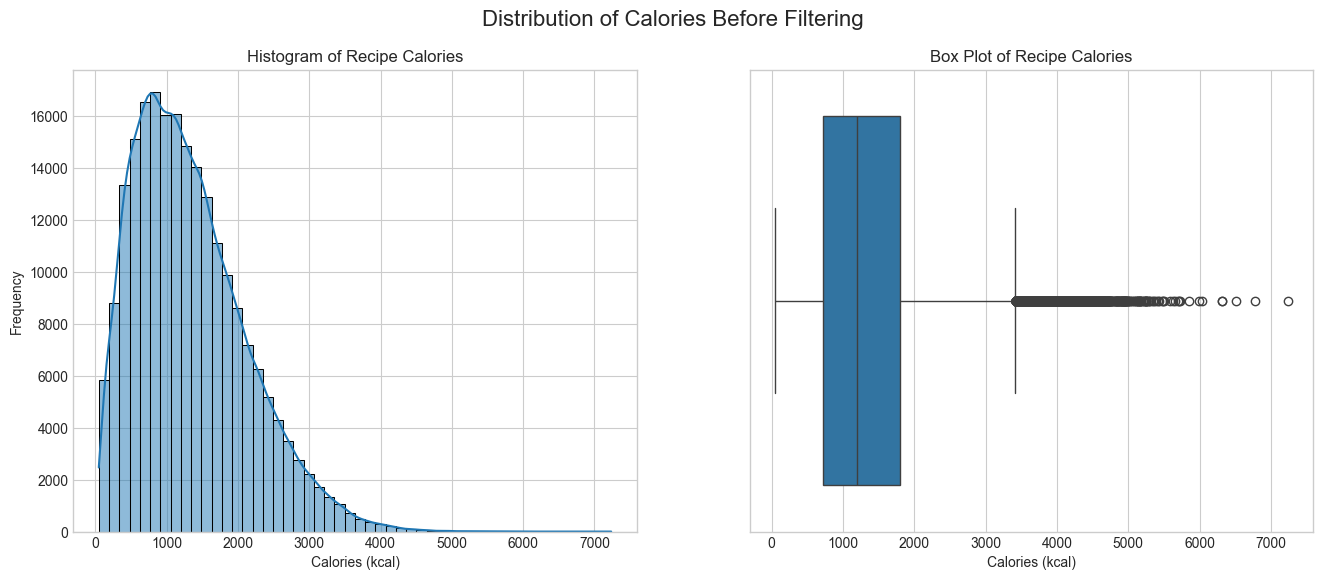

In [75]:

# --- 1.2: Trực quan hóa bằng Biểu đồ Histogram và Box Plot ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid') # Sử dụng một style đẹp hơn
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram: cho thấy tần suất của các giá trị calo
sns.histplot(clean_recipes_df['calories'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Histogram of Recipe Calories')
axes[0].set_xlabel('Calories (kcal)')
axes[0].set_ylabel('Frequency')

# Box Plot: giúp xác định rõ các điểm ngoại lai (outliers)
sns.boxplot(x=clean_recipes_df['calories'], ax=axes[1])
axes[1].set_title('Box Plot of Recipe Calories')
axes[1].set_xlabel('Calories (kcal)')

plt.suptitle('Distribution of Calories Before Filtering', fontsize=16)
plt.show()

In [76]:
# Tế bào 8 - Step 2 (Phiên bản Cải tiến V2)

# --- Step 2: Defining a Filtering Strategy and Applying the Filter ---
print("\n--- Step 2: Defining a Filtering Strategy and Applying the Filter ---")

# --- 2.1: Analyzing Different Percentile Thresholds ---
print("\n--- 2.1: Analyzing Different Percentile Thresholds ---")

# Tính toán các ngưỡng phân vị khác nhau
p90 = clean_recipes_df['calories'].quantile(0.90)
p95 = clean_recipes_df['calories'].quantile(0.95)
p98 = clean_recipes_df['calories'].quantile(0.98)
p99 = clean_recipes_df['calories'].quantile(0.99)

print(f"90th Percentile (p90): {p90:.2f} kcal. (Removing top 10% of data)")
print(f"95th Percentile (p95): {p95:.2f} kcal. (Removing top 5% of data)")
print(f"98th Percentile (p98): {p98:.2f} kcal. (Removing top 2% of data)")
print(f"99th Percentile (p99): {p99:.2f} kcal. (Removing top 1% of data)")



--- Step 2: Defining a Filtering Strategy and Applying the Filter ---

--- 2.1: Analyzing Different Percentile Thresholds ---
90th Percentile (p90): 2422.95 kcal. (Removing top 10% of data)
95th Percentile (p95): 2815.15 kcal. (Removing top 5% of data)
98th Percentile (p98): 3264.93 kcal. (Removing top 2% of data)
99th Percentile (p99): 3554.13 kcal. (Removing top 1% of data)


In [77]:

# --- 2.2: Selecting the Optimal Threshold and Justification ---
print("\n--- 2.2: Selecting the Optimal Threshold ---")

# Dựa trên phân tích biểu đồ, các giá trị thực sự cực đoan bắt đầu tăng mạnh sau khoảng 3500-4000 kcal.
# Ngưỡng p98 hoặc p99 có vẻ là một sự cân bằng tốt giữa việc loại bỏ outliers và giữ lại dữ liệu.
# Chúng ta sẽ chọn p98 để loại bỏ các giá trị cực đoan một cách mạnh mẽ hơn một chút.
FILTER_THRESHOLD = p98
print(f"Decision: The filtering threshold is set to the 98th percentile: {FILTER_THRESHOLD:.2f} kcal.")
print("This strategy removes the top 2% of recipes with the most extreme calorie counts,")
print("which are likely outliers due to large serving sizes or data processing assumptions.")



--- 2.2: Selecting the Optimal Threshold ---
Decision: The filtering threshold is set to the 98th percentile: 3264.93 kcal.
This strategy removes the top 2% of recipes with the most extreme calorie counts,
which are likely outliers due to large serving sizes or data processing assumptions.


In [78]:

# --- 2.3: Applying the Filter ---
print("\n--- 2.3: Applying the Filter ---")
initial_rows = len(clean_recipes_df)
recipes_filtered_df = clean_recipes_df[clean_recipes_df['calories'] <= FILTER_THRESHOLD].copy()
final_rows = len(recipes_filtered_df)

print(f"Removed {initial_rows - final_rows} outlier recipes ({ (initial_rows - final_rows) / initial_rows * 100 :.2f}% of the data).")

# --- Verification & Validation (After Filtering) ---
# ... (Phần code trực quan hóa sau khi lọc giữ nguyên như cũ) ...
# ...
# === GÁN LẠI ĐỂ SỬ DỤNG Ở CÁC BƯỚC SAU ===
clean_recipes_df = recipes_filtered_df
print("\n'clean_recipes_df' has been updated to the filtered version.")


--- 2.3: Applying the Filter ---
Removed 4359 outlier recipes (2.00% of the data).

'clean_recipes_df' has been updated to the filtered version.


In [79]:
clean_recipes_df.shape

(213580, 9)

In [80]:
clean_recipes_df.sample(5)

,name,description,steps,ingredients_list,calories,protein_g,fat_g,carbs_g,fiber_g
57914,cream of cheese soup,sprinkle each serving with paprika and garnish...,[melt butter in 3-quart saucepan over medium h...,"[butter, green onions, celery, water, half-and...",1100.83,8.66,84.98,77.53,3.80
213253,white cheese sauce,quick and easy bechamel or cheese sauce! grea...,[combine corn starch and milk in a small pan a...,"[cornstarch, milk, butter, salt, pepper]",1209.96,12.41,79.16,111.38,4.96
59440,creamy mashed pumpkin,i found this recipe from kraft and the family ...,[remove the seeds and skin from pumpkin and cu...,"[pumpkin, cheddar cheese, cream, black pepper,...",238.06,5.46,18.10,16.47,4.97
206787,uncle bill s fresh strawberries and dip,strawberry season is almost upon us in most pa...,"[combine vanilla yogurt , cream cheese and ora...","[vanilla yogurt, cream cheese, orange marmalad...",672.94,26.82,24.69,92.63,2.26
151928,pms bars,another variation of those famous magic layer ...,"[preheat oven to 350f, melt butter in 13x9"" pa...","[butter, graham cracker crumbs, sweetened cond...",1478.67,56.53,89.48,118.07,18.80


In [81]:
# --- Verification & Validation ---
print("\n--- Final Data Validation ---")

# Kiểm tra xem có tạo ra được công thức nào không
if not clean_recipes_df.empty:
    print(f"Total valid recipes created: {len(clean_recipes_df)} out of {SAMPLE_SIZE}")
    
    print("\nFirst 5 rows of the final clean dataset:")
    display(clean_recipes_df.head())
    
    print("\nChecking for null values in the final dataset:")
    if clean_recipes_df.isnull().sum().sum() == 0:
        print("No null values found.")
    else:
        print("WARNING: Null values still exist. This is unexpected.")
        print(clean_recipes_df.isnull().sum())
    
    print("\nDescriptive statistics of the final nutritional data:")
    # .describe() giúp phát hiện các giá trị bất thường (outliers) trong kết quả cuối cùng
    display(clean_recipes_df[['calories', 'protein_g', 'fat_g', 'carbs_g', 'fiber_g']].describe())
else:
    print("CRITICAL WARNING: No valid recipes were created.")
    print("This likely means the filtering condition 'matched_ingredients_count >= 2' is too strict,")
    print("or the ingredient normalization/matching logic is not effective enough.")
    print("Consider relaxing the condition to '>= 1' and re-running.")


--- Final Data Validation ---
Total valid recipes created: 213580 out of 20000

First 5 rows of the final clean dataset:


,name,description,steps,ingredients_list,calories,protein_g,fat_g,carbs_g,fiber_g
0,arriba baked winter squash mexican style,autumn is my favorite time of year to cook! th...,"[make a choice and proceed with recipe, depend...","[winter squash, mexican seasoning, mixed spice...",1544.67,21.52,98.92,148.94,12.25
1,a bit different breakfast pizza,this recipe calls for the crust to be prebaked...,"[preheat oven to 425 degrees f, press dough in...","[prepared pizza crust, sausage patty, eggs, mi...",966.62,74.66,62.71,30.69,5.52
2,all in the kitchen chili,this modified version of 'mom's' chili was a h...,"[brown ground beef in large pot, add chopped o...","[ground beef, yellow onions, diced tomatoes, t...",685.64,15.35,3.60,173.64,49.36
3,alouette potatoes,"this is a super easy, great tasting, make ahea...",[place potatoes in a large pot of lightly salt...,"[spreadable cheese with garlic and herbs, new ...",1147.83,48.52,25.24,195.49,34.20
4,amish tomato ketchup for canning,my dh's amish mother raised him on this recipe...,"[mix all ingredients& boil for 2 1 / 2 hours ,...","[tomato juice, apple cider vinegar, sugar, sal...",669.83,13.05,31.00,87.10,13.55



Checking for null values in the final dataset:
No null values found.

Descriptive statistics of the final nutritional data:


,calories,protein_g,fat_g,carbs_g,fiber_g
count,213580.00,213580.00,213580.00,213580.00,213580.00
mean,1282.14,40.74,70.35,131.81,19.45
std,717.25,26.83,55.41,79.18,18.18
min,50.12,0.00,0.00,0.00,0.00
25%,715.48,19.17,23.30,71.40,6.70
50%,1182.86,37.27,54.14,119.64,13.67
75%,1757.59,57.33,112.04,180.61,26.18
max,3264.80,257.40,320.47,604.56,198.43


In [100]:
import os
# --- Bắt buộc: Cần cài đặt một engine để ghi Parquet ---

# -----------------------------------------------------

# Định nghĩa đường dẫn thư mục dự án
project_dir = os.getcwd()  # Lấy thư mục làm việc hiện tại (thư mục dự án)
output_dir = os.path.join(project_dir, 'output')  # Tạo thư mục con 'output' trong thư mục dự án

# --- Thay đổi tại đây ---
# 1. Đổi tên file từ .csv thành .parquet
parquet_path = os.path.join(output_dir, 'clean_recipes_df.parquet')

# 2. Đổi hàm .to_csv() thành .to_parquet()
#    (Vẫn giữ index=False, đây là thói quen tốt)
# Thay vì 'pyarrow', hãy dùng 'fastparquet'
clean_recipes_df.to_parquet(parquet_path, index=False, engine='fastparquet')
# 3. Cập nhật thông báo
print(f"Saved data to Parquet: {parquet_path}")

Saved data to Parquet: /Users/nguyenthuong/Documents/DietPlanning/output/clean_recipes_df.parquet


In [86]:
# Tế bào 1: Tải Dữ liệu Sạch và Thiết lập Môi trường

# --- Objective ---
# Tải bộ dữ liệu đã được tiền xử lý và chuẩn bị môi trường cho việc phân tích.

# --- Implementation ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---
# Cấu hình để hiển thị số thực với 2 chữ số thập phân
pd.options.display.float_format = '{:.2f}'.format
# Thiết lập style cho biểu đồ để trông chuyên nghiệp hơn
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2) # Tăng kích thước font chữ cho dễ đọc

# --- Load Data ---
print("--- Loading Processed Data ---")
processed_data_path = 'output/clean_recipes_df.csv'
try:
    df = pd.read_csv(processed_data_path)
    print(f"Clean dataset loaded successfully from '{processed_data_path}'.")
except Exception as e:
    print(f"ERROR loading file: {e}")
    print("Please ensure you have run the data processing notebook (02_Data_Processing.ipynb) successfully.")

# --- Verification ---
print("\n--- Initial Data Verification ---")
if 'df' in locals():
    print(f"DataFrame shape: {df.shape}")
    print("\nFirst 5 rows of the dataset:")
    display(df.head())
    print("\nDescriptive statistics:")
    display(df.describe())
else:
    print("Data not loaded. Cannot proceed with analysis.")

--- Loading Processed Data ---
Clean dataset loaded successfully from 'output/clean_recipes_df.csv'.

--- Initial Data Verification ---
DataFrame shape: (213580, 9)

First 5 rows of the dataset:


,name,description,steps,ingredients_list,calories,protein_g,fat_g,carbs_g,fiber_g
0,arriba baked winter squash mexican style,autumn is my favorite time of year to cook! th...,"['make a choice and proceed with recipe', 'dep...","['winter squash', 'mexican seasoning', 'mixed ...",1544.67,21.52,98.92,148.94,12.25
1,a bit different breakfast pizza,this recipe calls for the crust to be prebaked...,"['preheat oven to 425 degrees f', 'press dough...","['prepared pizza crust', 'sausage patty', 'egg...",966.62,74.66,62.71,30.69,5.52
2,all in the kitchen chili,this modified version of 'mom's' chili was a h...,"['brown ground beef in large pot', 'add choppe...","['ground beef', 'yellow onions', 'diced tomato...",685.64,15.35,3.60,173.64,49.36
3,alouette potatoes,"this is a super easy, great tasting, make ahea...",['place potatoes in a large pot of lightly sal...,"['spreadable cheese with garlic and herbs', 'n...",1147.83,48.52,25.24,195.49,34.20
4,amish tomato ketchup for canning,my dh's amish mother raised him on this recipe...,['mix all ingredients& boil for 2 1 / 2 hours ...,"['tomato juice', 'apple cider vinegar', 'sugar...",669.83,13.05,31.00,87.10,13.55



Descriptive statistics:


,calories,protein_g,fat_g,carbs_g,fiber_g
count,213580.00,213580.00,213580.00,213580.00,213580.00
mean,1282.14,40.74,70.35,131.81,19.45
std,717.25,26.83,55.41,79.18,18.18
min,50.12,0.00,0.00,0.00,0.00
25%,715.48,19.17,23.30,71.40,6.70
50%,1182.86,37.27,54.14,119.64,13.67
75%,1757.59,57.33,112.04,180.61,26.18
max,3264.80,257.40,320.47,604.56,198.43


--- Generating Distribution and Box Plots for each nutritional feature ---


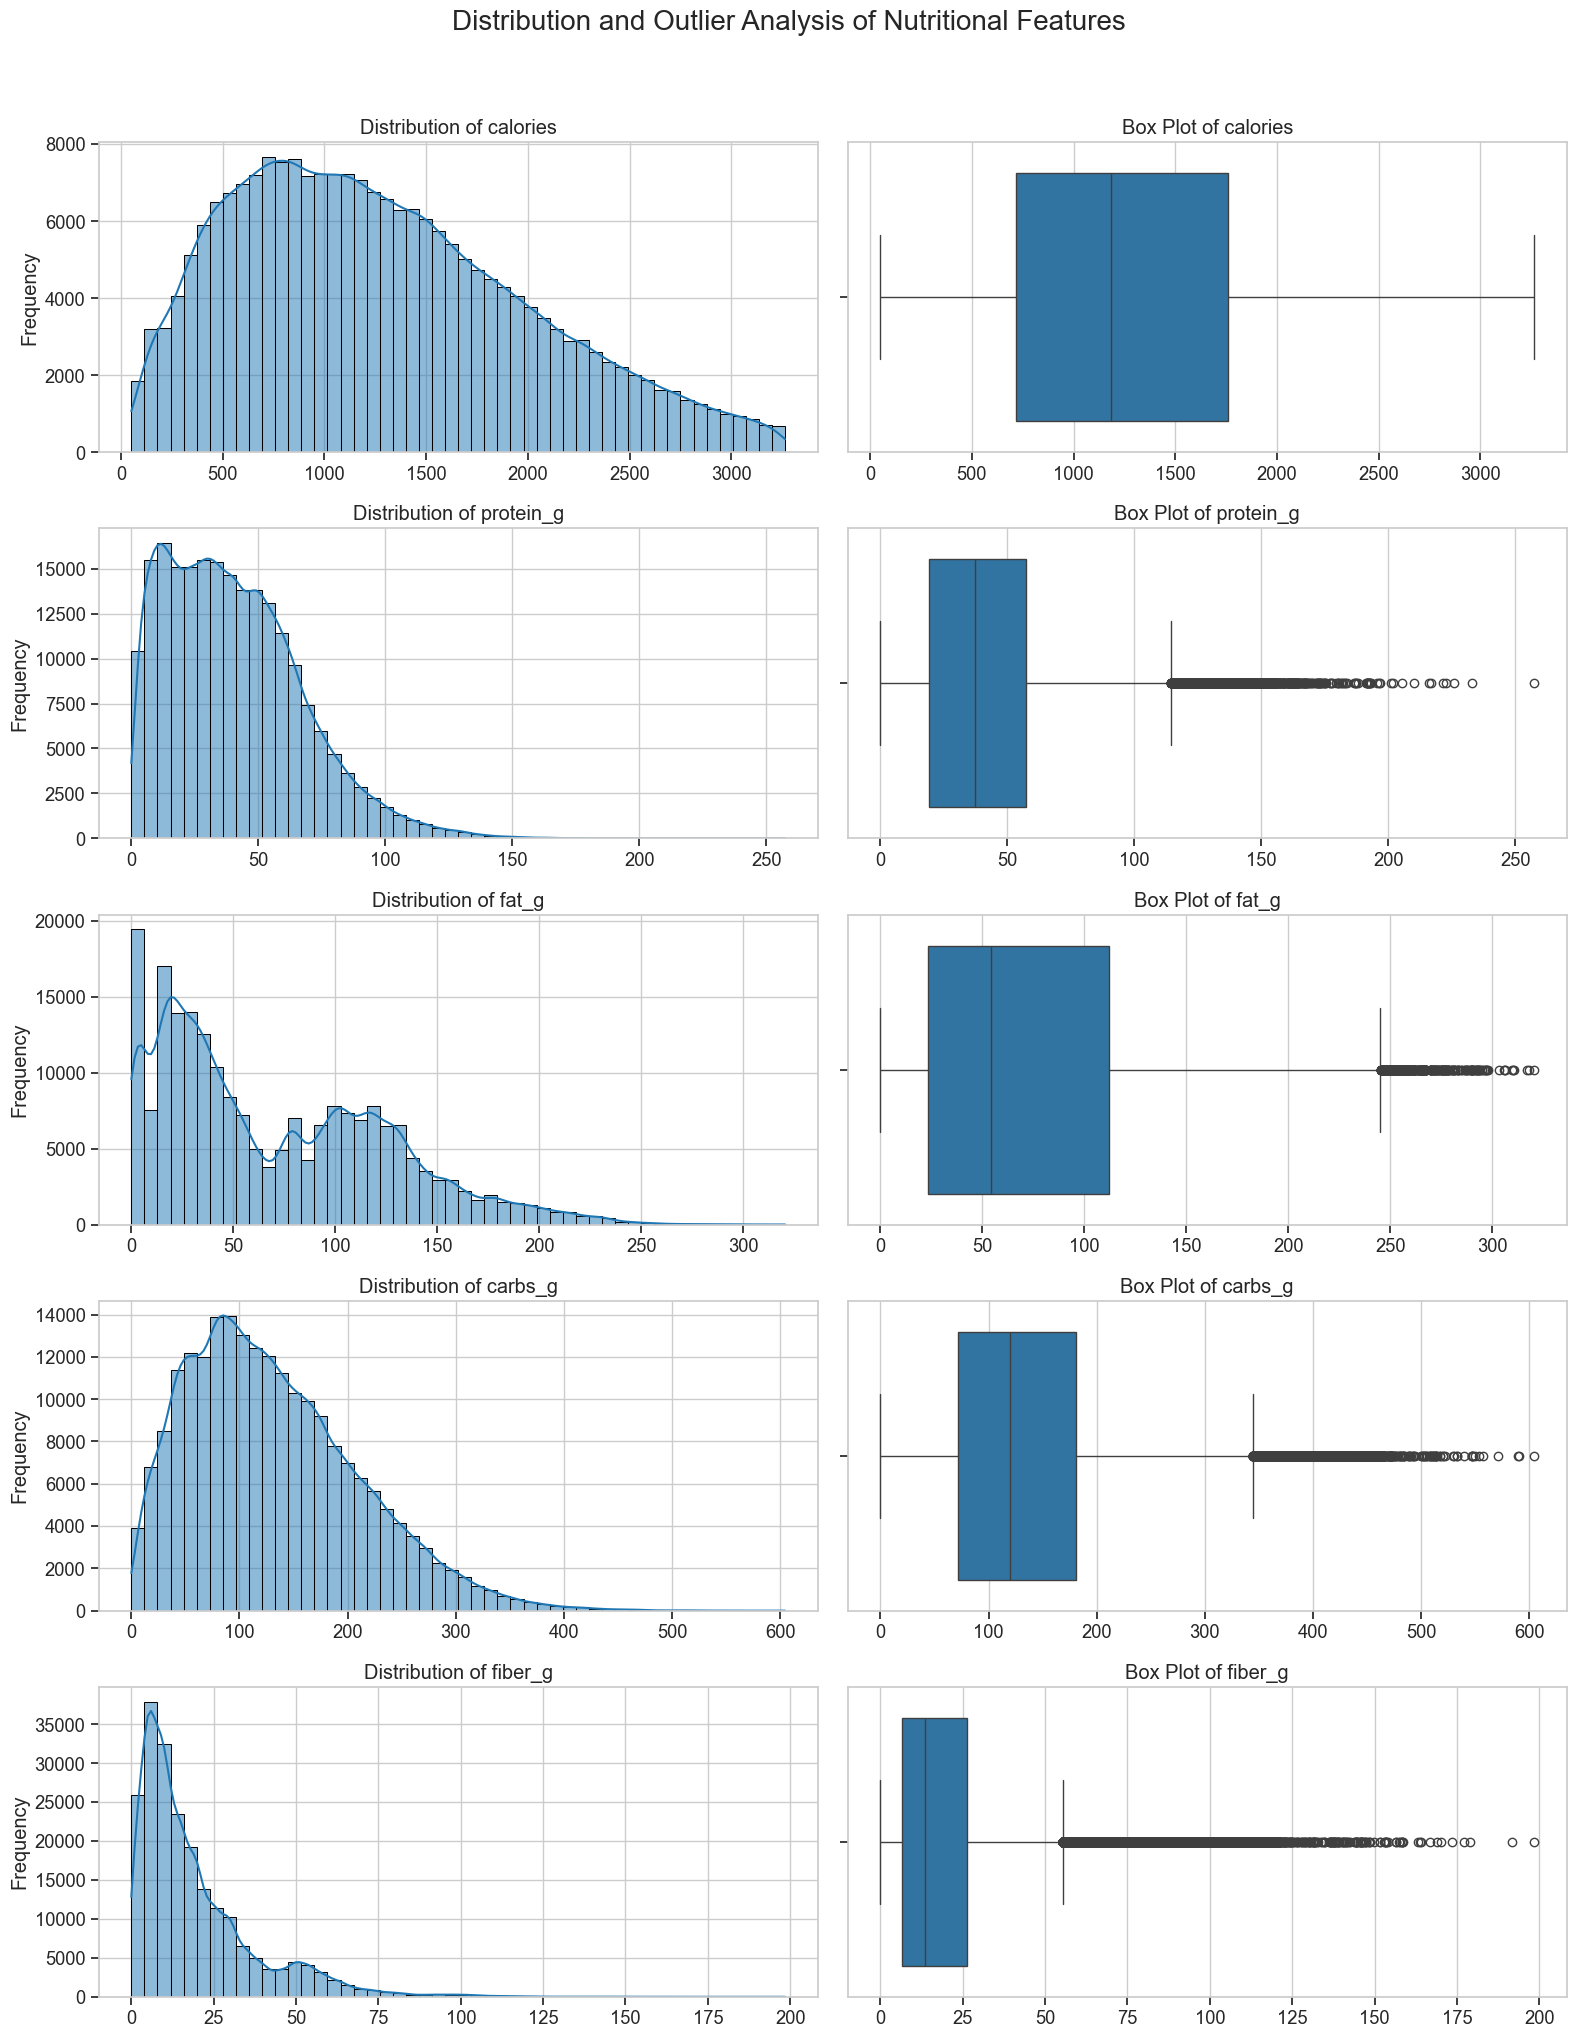

In [87]:
# Tế bào 2: Trực quan hóa Phân phối (Histogram & Box Plot)

# --- Objective ---
# Trực quan hóa sự phân bổ của từng đặc trưng dinh dưỡng để hiểu rõ
# về xu hướng trung tâm, độ lệch và các giá trị ngoại lai.

# --- Implementation ---
print("--- Generating Distribution and Box Plots for each nutritional feature ---")
# Danh sách các cột dinh dưỡng chúng ta muốn phân tích
nutritional_features = ['calories', 'protein_g', 'fat_g', 'carbs_g', 'fiber_g']

# Tạo một lưới biểu đồ (grid) để hiển thị
# len(nutritional_features) hàng, 2 cột. Kích thước (16, 20)
fig, axes = plt.subplots(len(nutritional_features), 2, figsize=(16, 20))

# Đặt một tiêu đề chung cho toàn bộ hình
fig.suptitle('Distribution and Outlier Analysis of Nutritional Features', fontsize=20, y=1.02)

# Lặp qua từng đặc trưng và vẽ biểu đồ
for i, feature in enumerate(nutritional_features):
    # --- Biểu đồ 1: Histogram & KDE (Bên trái) ---
    sns.histplot(data=df, x=feature, bins=50, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution of {feature}')
    axes[i, 0].set_xlabel('') # Bỏ nhãn trục x để đỡ rối
    axes[i, 0].set_ylabel('Frequency')
    
    # --- Biểu đồ 2: Box Plot (Bên phải) ---
    sns.boxplot(data=df, x=feature, ax=axes[i, 1])
    axes[i, 1].set_title(f'Box Plot of {feature}')
    axes[i, 1].set_xlabel('') # Bỏ nhãn trục x

# Tự động điều chỉnh layout để các biểu đồ không bị đè lên nhau
plt.tight_layout(rect=[0, 0, 1, 1]) # rect để tiêu đề chung không bị cắt
plt.show()

--- Generating the Correlation Matrix Heatmap ---


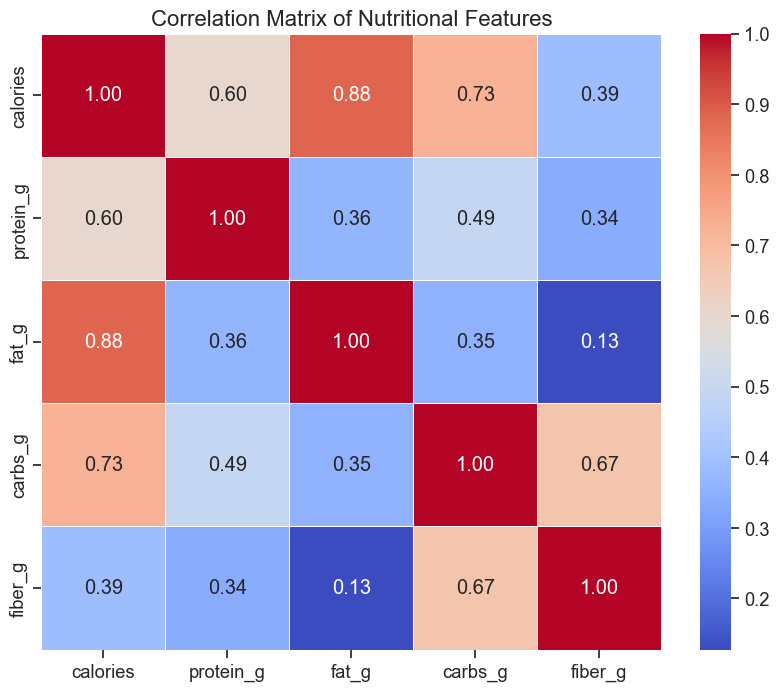


Correlation Matrix Data:


,calories,protein_g,fat_g,carbs_g,fiber_g
calories,1.00,0.60,0.88,0.73,0.39
protein_g,0.60,1.00,0.36,0.49,0.34
fat_g,0.88,0.36,1.00,0.35,0.13
carbs_g,0.73,0.49,0.35,1.00,0.67
fiber_g,0.39,0.34,0.13,0.67,1.00


In [88]:
# Tế bào 3: Ma trận Tương quan (Heatmap)

# --- Objective ---
# Tính toán và trực quan hóa ma trận tương quan Pearson để định lượng
# mối quan hệ tuyến tính giữa các cặp đặc trưng dinh dưỡng.

# --- Implementation ---
print("--- Generating the Correlation Matrix Heatmap ---")

# 1. Tính toán ma trận tương quan
correlation_matrix = df[nutritional_features].corr(method='pearson')

# 2. Vẽ biểu đồ nhiệt (Heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True,        # Hiển thị các con số trên ô
    cmap='coolwarm',   # Chọn bảng màu (màu ấm cho tương quan dương, màu lạnh cho tương quan âm)
    fmt='.2f',         # Định dạng số hiển thị với 2 chữ số thập phân
    linewidths=.5      # Tạo đường kẻ giữa các ô
)
plt.title('Correlation Matrix of Nutritional Features', fontsize=16)
plt.show()

# --- Verification ---
print("\nCorrelation Matrix Data:")
display(correlation_matrix)

--- Generating Pair Plot (on a sample of 5000 recipes) ---
This may take a moment to render...


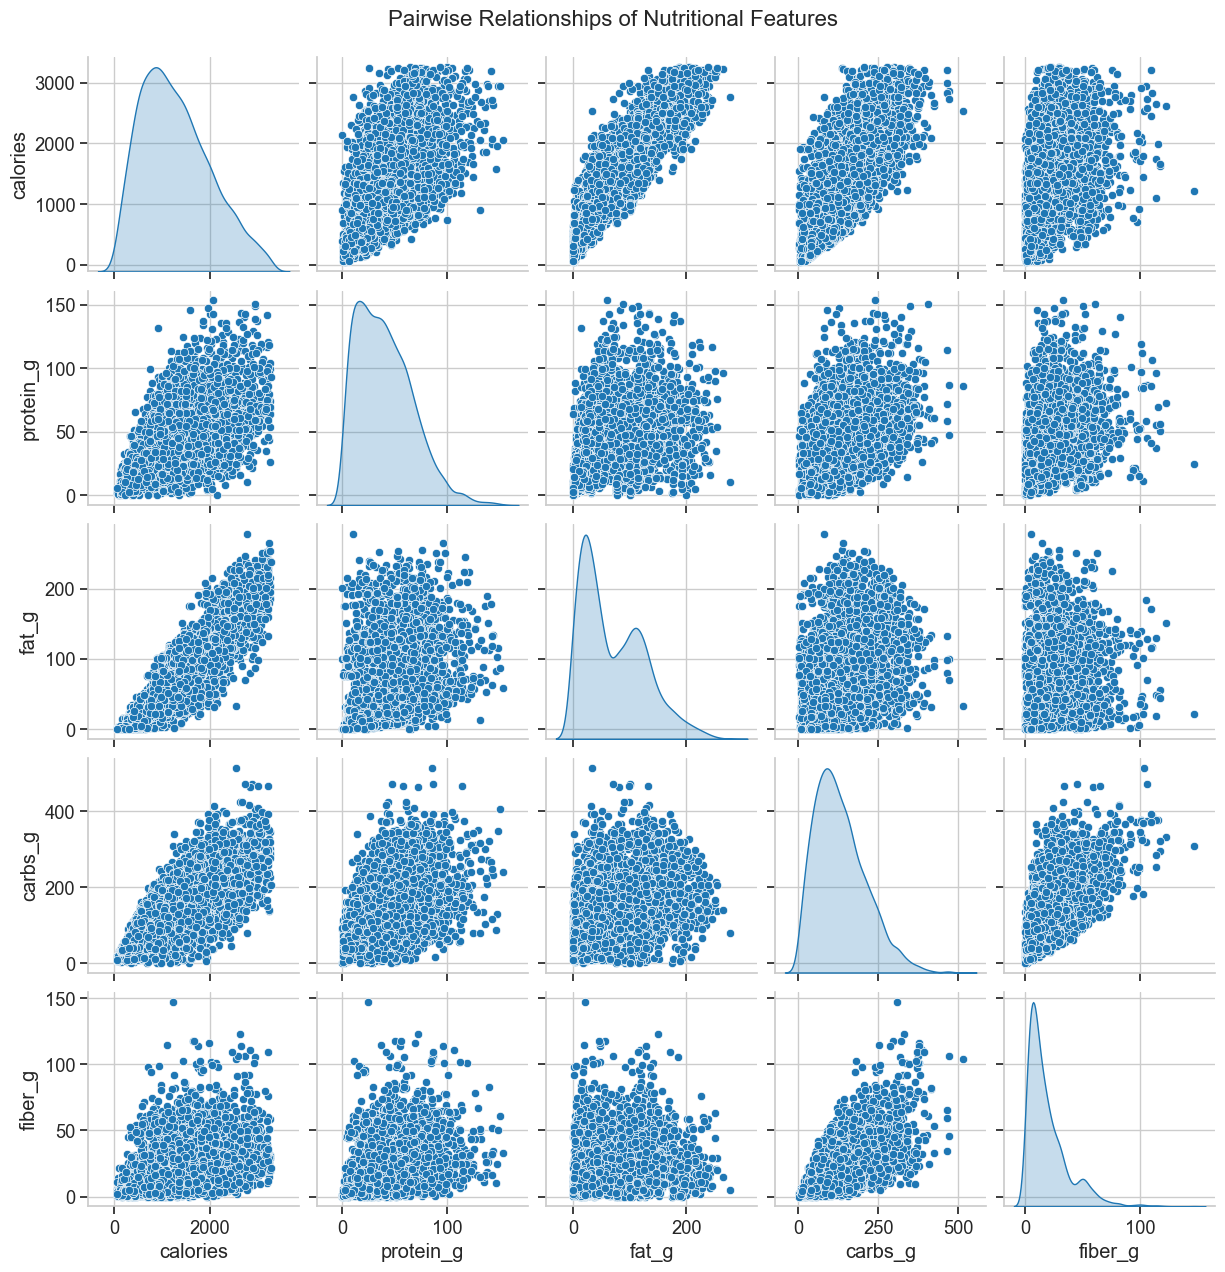

In [90]:
# Tế bào 4: Biểu đồ Phân tán Cặp đôi (Pair Plot)

# --- Objective ---
# Trực quan hóa mối quan hệ giữa từng cặp đặc trưng (scatterplot)
# và phân phối của từng đặc trưng (histogram/KDE) để tìm kiếm các cấu trúc cụm tiềm ẩn.

# Cảnh báo: Lệnh này rất tốn tài nguyên. Chúng ta sẽ chỉ chạy trên một mẫu nhỏ.
SAMPLE_SIZE_FOR_PLOT = 5000

# --- Implementation ---
print(f"--- Generating Pair Plot (on a sample of {SAMPLE_SIZE_FOR_PLOT} recipes) ---")
print("This may take a moment to render...")

# Lấy một mẫu ngẫu nhiên để vẽ biểu đồ
df_sample = df.sample(n=SAMPLE_SIZE_FOR_PLOT, random_state=42)

# Vẽ pair plot
pair_plot = sns.pairplot(
    df_sample[nutritional_features],
    diag_kind='kde' # Vẽ biểu đồ mật độ trên đường chéo
)
pair_plot.fig.suptitle('Pairwise Relationships of Nutritional Features', y=1.02, fontsize=16)
plt.show()

In [51]:
# Tế bào 6 (Phiên bản Cải tiến V2)

# --- Objective ---
# 1. Cải tiến logic chuẩn hóa để xử lý các biến thể (số nhiều, cụm từ).
# 2. Cải tiến logic tìm kiếm để tăng khả năng khớp thành công.
# 3. Đảm bảo Unit Test hoạt động chính xác.

# --- Implementation ---

def normalize_ingredient(ing_name: str) -> str:
    """Chuẩn hóa chuỗi tên thành phần để tối ưu hóa việc tìm kiếm."""
    if not isinstance(ing_name, str):
        return ""
    ing_name = ing_name.lower()
    # Logic: lấy phần văn bản trước dấu phẩy đầu tiên
    ing_name = ing_name.split(',')[0]
    # Loại bỏ số lượng và các đơn vị
    ing_name = re.sub(r'(\d+/\d+|\d+\s\d+/\d+|\d+\.\d+|\d+)\s*(oz|ounce|s|g|gram|s|kg|lb|s|cup|s|teaspoon|s|tablespoon|s|can|s|package|s|cloves|clove)\b', '', ing_name)
    # Loại bỏ các từ mô tả
    ing_name = re.sub(r'\b(diced|chopped|fresh|minced|sliced|cooked|frozen|canned|peeled|seeded|to taste|optional|large|small|medium|thinly|roughly|pitted|crushed|undrained|drained|all-purpose)\b', '', ing_name)
    # Loại bỏ các ký tự đặc biệt
    ing_name = re.sub(r'[^a-z\s-]', '', ing_name)
    # Xử lý số nhiều đơn giản bằng cách loại bỏ 's' hoặc 'es' ở cuối
    words = ing_name.split()
    normalized_words = []
    for word in words:
        if word.endswith('es'):
            normalized_words.append(word[:-2])
        elif word.endswith('s'):
            normalized_words.append(word[:-1])
        else:
            normalized_words.append(word)
    
    return ' '.join(normalized_words).strip()


def process_recipe_row(row: pd.Series, lookup_df: pd.DataFrame) -> dict or None:
    """
    Xử lý một hàng của DataFrame công thức, tính toán tổng dinh dưỡng.
    Sử dụng logic tìm kiếm thông minh hơn.
    """
    try:
        ingredients_list = eval(row['ingredients'])
        steps_list = eval(row['steps'])
    except Exception:
        return None

    total_nutrition = {'calories': 0.0, 'protein_g': 0.0, 'fat_g': 0.0, 'carbs_g': 0.0, 'fiber_g': 0.0}
    matched_ingredients_count = 0

    for ing in ingredients_list:
        clean_ing = normalize_ingredient(ing)
        if not clean_ing or len(clean_ing) < 3:
            continue
        
        # --- Logic Tìm kiếm Thông minh ---
        match = None
        # Ưu tiên 1: Tìm kiếm trùng khớp chính xác
        exact_match = lookup_df[lookup_df['semantic_root'] == clean_ing]
        if not exact_match.empty:
            match = exact_match.iloc[0]
        else:
            # Ưu tiên 2: Tách thành các từ và tìm kiếm từng từ
            words_in_ing = clean_ing.split()
            # Tìm từ dài nhất để tìm kiếm (thường là từ mang nhiều ý nghĩa nhất)
            if words_in_ing:
                longest_word = max(words_in_ing, key=len)
                if len(longest_word) > 2:
                    partial_matches = lookup_df[lookup_df['semantic_root'].str.contains(r'\b' + longest_word + r'\b', na=False)] # Tìm từ hoàn chỉnh
                    if not partial_matches.empty:
                        # Ưu tiên kết quả ngắn nhất trong các kết quả khớp
                        best_match_idx = partial_matches['semantic_root'].str.len().idxmin()
                        match = partial_matches.loc[best_match_idx]

        if match is not None:
            matched_ingredients_count += 1
            for nutrient in total_nutrition.keys():
                total_nutrition[nutrient] += match[nutrient]
    
    # Giữ nguyên điều kiện lọc
    if total_nutrition['calories'] > 50 and matched_ingredients_count >= 2:
        return {
            'name': row['name'],
            'description': row['description'],
            'steps': steps_list,
            'ingredients_list': ingredients_list,
            **total_nutrition
        }
    return None

In [52]:

# --- Verification & Validation (Cập nhật) ---
print("Processing functions (V2) are defined.")
print("\n--- Unit Testing the Functions (V2) ---")
test_row = pd.Series({
    'ingredients': "['1 cup all-purpose flour', '2 large eggs', 'some unknown ingredient', 'salt']",
    'steps': "['mix flour and eggs']", 'name': 'Test Cake', 'description': 'A simple test cake'
})
test_lookup = pd.DataFrame({
    'semantic_root': ['flour', 'egg', 'salt', 'eggplant'],
    'calories': [364.0, 139.5, 0.0, 35.5], 'protein_g': [10.33, 12.75, 0.0, 0.89],
    'fat_g': [0.98, 7.78, 0.0, 0.33], 'carbs_g': [76.31, 4.23, 0.0, 8.13],
    'fiber_g': [2.7, 0.0, 0.0, 2.62]
})
print("Testing with a sample row...")
result = process_recipe_row(test_row, test_lookup)

expected_calories = 364.0 + 139.5 + 0.0 # flour + egg + salt
# Cập nhật điều kiện kiểm tra: bây giờ chúng ta khớp được 3 thành phần
expected_matched_count = 3 

if result and abs(result['calories'] - expected_calories) < 0.01:
    print(f"Unit test passed! Calculated calories are correct (~{result['calories']:.2f}).")
else:
    print("Unit test failed! Check the logic in process_recipe_row.")
    print(f"Expected calories: {expected_calories}, Got: {result.get('calories') if result else 'None'}")
    # Thêm debug:
    if result is None:
        print("Reason: The function returned None. The filtering condition 'if total_nutrition['calories'] > 50 and matched_ingredients_count >= 2:' might not be met.")

Processing functions (V2) are defined.

--- Unit Testing the Functions (V2) ---
Testing with a sample row...
Unit test passed! Calculated calories are correct (~503.50).


In [101]:
from sklearn.preprocessing import StandardScaler

In [102]:
# Tế bào 5: Chuẩn bị Dữ liệu cho Mô hình K-Means
# --- Implementation ---

print("--- Step 1: Feature Selection and Scaling ---")

# 1.1: Lựa chọn các đặc trưng dinh dưỡng
# Đây là các biến số mà K-Means sẽ sử dụng để đo lường "sự tương đồng" giữa các công thức.
nutritional_features = ['calories', 'protein_g', 'fat_g', 'carbs_g', 'fiber_g']
X = df[nutritional_features]

--- Step 1: Feature Selection and Scaling ---


In [103]:
# --- Verification 1.1 ---
print("\n--- Verification 1.1: Selected Features ---")
print(f"Features for modeling: {nutritional_features}")
print(f"Shape of feature matrix X: {X.shape}")
print("First 5 rows of feature matrix:")
display(X.head())
print("-" * 60)


--- Verification 1.1: Selected Features ---
Features for modeling: ['calories', 'protein_g', 'fat_g', 'carbs_g', 'fiber_g']
Shape of feature matrix X: (213580, 5)
First 5 rows of feature matrix:


,calories,protein_g,fat_g,carbs_g,fiber_g
0,1544.67,21.52,98.92,148.94,12.25
1,966.62,74.66,62.71,30.69,5.52
2,685.64,15.35,3.60,173.64,49.36
3,1147.83,48.52,25.24,195.49,34.20
4,669.83,13.05,31.00,87.10,13.55


------------------------------------------------------------


In [104]:
# 1.2: Chuẩn hóa dữ liệu
# K-Means dựa trên khoảng cách Euclidean. Nếu không chuẩn hóa, 'calories' (có giá trị hàng nghìn)
# sẽ lấn át hoàn toàn 'fiber_g' (có giá trị vài chục), làm cho mô hình bị sai lệch.
# StandardScaler sẽ biến đổi dữ liệu sao cho mỗi đặc trưng có giá trị trung bình là 0 và độ lệch chuẩn là 1.
print("\n--- Step 1.2: Scaling the Features ---")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Chuyển đổi mảng NumPy kết quả thành DataFrame để dễ kiểm tra
X_scaled_df = pd.DataFrame(X_scaled, columns=nutritional_features)


--- Step 1.2: Scaling the Features ---


In [105]:
# --- Verification 1.2 ---
print("\n--- Verification 1.2: Scaled Features ---")
print("Features have been scaled using StandardScaler.")
print("The mean of each scaled feature should be close to 0, and the standard deviation should be close to 1.")
print("\nDescriptive statistics of the scaled data:")
display(X_scaled_df.describe())


--- Verification 1.2: Scaled Features ---
Features have been scaled using StandardScaler.
The mean of each scaled feature should be close to 0, and the standard deviation should be close to 1.

Descriptive statistics of the scaled data:


,calories,protein_g,fat_g,carbs_g,fiber_g
count,213580.00,213580.00,213580.00,213580.00,213580.00
mean,0.00,-0.00,0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00
min,-1.72,-1.52,-1.27,-1.66,-1.07
25%,-0.79,-0.80,-0.85,-0.76,-0.70
50%,-0.14,-0.13,-0.29,-0.15,-0.32
75%,0.66,0.62,0.75,0.62,0.37
max,2.76,8.07,4.51,5.97,9.84
